# USD AAI 511 - Assignment #6 - Build an Autoencoder Neural Network

by Bryan Carr

8 August 2022

In this assignment, we will build an autoencoder to break down and rebuild the 28x28 pixel handwritten digits of the MNIST dataset. The MNIST dataset will be sourced from Keras' built-in datasets libraries.

## 6.1: Setting up Libraries and Data

First up, I will import the required libraries, set random seeds, and import the data set.

In [31]:
# Import Key Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Flatten, Dense, Reshape


In [2]:
# Set random seeds -- using 808 for the 8th of August (8th month)
np.random.seed(808)
tf.random.set_seed(808)

In [3]:
# Import MNIST dataset
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
# Reshape data as Array and rescale as Greyscale

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train.astype('float32') / 255.0

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test.astype('float32') / 255.0

In [6]:
x_train.shape

(60000, 28, 28, 1)

## 6.2: Build and Fit A Model

I had success in Assignment 3 with a fairly simple CNN. I will aim to replicate it here as the first model, mirroring the encoding layers as the decoder.

The architecture was:

Inputs -> 3x3 Convolution w/ 32 Filters -> 2x2 Max Pooling -> 3x3 Convolution, 64 layers -> 2x2 Max Pooling -> Flatten -> Dense layer, 500 nodes -> Dense layer, 64 nodes -> Classification layer

I will try using the 200 nodes as the Bottleneck layer, as 64 seems too small to capture the many variances, and 500 seems too large (and would have many many more parameters to train)

In [7]:
model1 = Sequential(name='Autoencoder1')

#First Convolution Layer
model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1), name='Conv1'))
#model1.add(Dropout(rate=0.2))
model1.add(MaxPool2D(pool_size=(2,2)))

#Second Convolution Layer
model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

# Bottleneck: Flatten and Dense Layer
model1.add(Flatten())
model1.add(Dense(units=200, activation='relu'))


In [9]:
# Continue adding the Decoder, which mirrors the above architecture

# Reshape layer
# this Dense layer expands it back to the size we had flattened from
# I want a size of 7x7 for easy expansion. That requires: 7*7*64 = 3136 nodes
model1.add(Dense(3136))  
model1.add(Reshape(target_shape=(7,7,64)))

#Add Conv2D Transpose layer
# Our Transpose layers need to go 1 further in terms of Filters
# FIrst layer reduces from 64 to 32 filters
model1.add(Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='relu'))

# Add 2nd Conv2D Transpose layer
# This second layer reduces down to 1 filter, i.e. the Grayscale value
# We also use Sigmoid activation to scale the results well in the 0-to-1 range
model1.add(Conv2DTranspose(filters=1, kernel_size=(3,3), strides=2, padding='same', activation='sigmoid'))


In [10]:
print(model1.summary())

Model: "Autoencoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 200)              

In [11]:
## Now it is time to compile and train the model

model1.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
# Fit the model and record its History, for plotting purposes

history1 = model1.fit(x=x_train, y=x_train, batch_size=100, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
480/480 [==============================] - 10s 9ms/step - loss: 0.1535 - val_loss: 0.0909
Epoch 2/20
480/480 [==============================] - 3s 5ms/step - loss: 0.0839 - val_loss: 0.0808
Epoch 3/20
480/480 [==============================] - 3s 6ms/step - loss: 0.0777 - val_loss: 0.0769
Epoch 4/20
480/480 [==============================] - 3s 5ms/step - loss: 0.0748 - val_loss: 0.0745
Epoch 5/20
480/480 [==============================] - 3s 6ms/step - loss: 0.0729 - val_loss: 0.0731
Epoch 6/20
480/480 [==============================] - 3s 5ms/step - loss: 0.0717 - val_loss: 0.0719
Epoch 7/20
480/480 [==============================] - 3s 5ms/step - loss: 0.0707 - val_loss: 0.0712
Epoch 8/20
480/480 [==============================] - 3s 6ms/step - loss: 0.0700 - val_loss: 0.0704
Epoch 9/20
480/480 [==============================] - 3s 6ms/step - loss: 0.0694 - val_loss: 0.0702
Epoch 10/20
480/480 [==============================] - 3s 6ms/step - loss: 0.0689 - val_loss: 0.069

## 6.3: Evaluate our Model

Time to evaluate the model. I will plot the training progress curves, as well as some sample images.


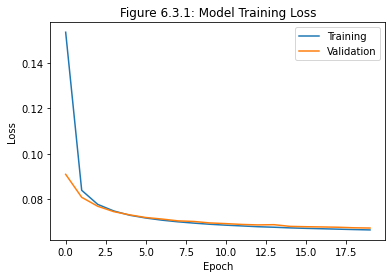

In [21]:
# Plot training history by Epoch

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Figure 6.3.1: Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [14]:
# Make predictions with our model

x_pred = model1.predict(x_test)

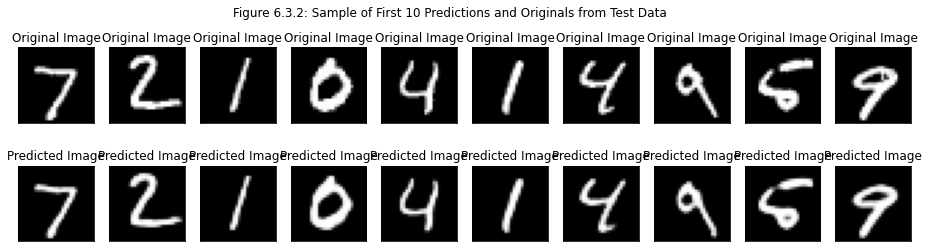

In [32]:
# Visualize predictions

n = 10
plt.figure(figsize=(16,4))

for i in range(n):
  # Plot Original images
  ax = plt.subplot(2, n, i+1)
  ax.set_title("Original Image")
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #Plot Predicted images
  ax = plt.subplot(2, n, i+1+n)
  ax.set_title("Predicted Image")
  plt.imshow(x_pred[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.suptitle('Figure 6.3.2: Sample of First 10 Predictions and Originals from Test Data')
plt.show()

In [28]:
# Evaluate the Mean Squared Error across all samples

mse = tf.keras.metrics.MeanSquaredError()
mse.update_state(x_test, x_pred)
mse.result().numpy()

0.0020853113

In [29]:
# Evaluate the Mean Absolute Error across all samples

mae = tf.keras.metrics.MeanAbsoluteError()
mae.update_state(x_test, x_pred)
mae.result().numpy()

0.013470813

In [30]:
# Evaluate the Binary Cross Entropy loss across all samples

bce = tf.keras.metrics.BinaryCrossentropy()
bce.update_state(x_test, x_pred)
bce.result().numpy()

0.06638464

## 6.4: Conclusions

During trianing, we saw the model quickly converge to less than 8% validation loss, demonstrating some good progress. Progress continued to be observed through all 20 epochs, albeit slowly.

We can see from Fig 6.3.2 that the model is creating very visually accurate reproductions of the test images. The most notable error appears to be removing a small line in the final "9" image, which itself appears to be an error/smudge and not indicative of an actual number 9.

Metric-wise, we see very good performance:

MSE of 0.002,

MAE of 0.013,

and Binary Cross Entropy of 6.6%.

Across 10,000 samples of 28x28 grayscale images (data ranging in 1/255 size steps from 0 to 1), these are very low errors to be observing. I am quite satisfied with the results.

## 6.5: References

I was assisted by a coding tutorial on youtube, as well as an article by Dr. Brownlee to try and help understand the Conv2DTranspose layer.


Brownlee, J. (2019, June 24). How to use the UpSampling2D and Conv2DTranspose Layers in Keras. MachineLearningMastery.Com. https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/

Tomar, N. [Idiot Developer]. (2021). Convolutional Autoencoder in TensorFlow 2.0 (Keras) - Deep Learning [Video]. YouTube. https://www.youtube.com/watch?v=1X7wPWnVkHg